In [30]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import copy

from keras import Model, Sequential
from keras.optimizers import  Adam
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [31]:
def prepare_data(df_list, T=10):
    data = []
    masks = []
    for df in df_list:
        x = []
        y = []
        for i in range(len(fog_idxs)):
            inputrow = []
            outputrow = []
            for counter in range(0, len(df[df['Fog node'] == fog_idxs[i]])-T-1):
                inputrow.append(np.array(df[df['Fog node'] == fog_idxs[i]][feature_cols].iloc[counter:counter+T, :]))
                inputrow[-1][-1, -1] = 0.0
                outputrow.append(np.array(df[df['Fog node'] == fog_idxs[i]][label_cols].iloc[counter+T-1, :]))
            inputdf = np.array(inputrow)
            outputdf = np.array(outputrow)
            x.append(np.float32(inputdf))
            y.append(np.float32(outputdf))
        d = dict()
        d['x'] = np.array(x)
        d['y'] = np.array(y)
        sizes = [len(y[i]) for i in range(len(fog_idxs))]
        mask = np.equal(sizes, 0)
        data.append(d)
        masks.append(mask)
    return data, masks


def normalize(vec):
    max_val = max(vec)
    min_val = min(vec)
    return (vec - min_val) / (max_val - min_val)


class LocalModel(Model):
  def __init__(self, T):
    super(LocalModel, self).__init__()
    self.lstm1 = LSTM(100, input_shape=(T, len(feature_cols)))
    self.dense1 = Dense(100)
    self.dense2 = Dense(1, activation='sigmoid')

  def call(self, inputs):
    x = self.lstm1(inputs)
    x = self.dense1(x)
    x = self.dense2(x)
    return x


def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis=0)


def fed_att(g_model, l_models, mask):
    g_model_next = copy.deepcopy(g_model)
    L = len(g_model.layers)
    K = len(l_models)
    g_lr = 0.001
    for l in range(L):
        s = np.zeros((K, L))
        for k in range(K):
            for i in range(len(g_model.layers[l].get_weights())):
                s[k, l] += np.linalg.norm(g_model.layers[l].get_weights()[i] - l_models[k].layers[l].get_weights()[i])
    att = softmax(s)
    for l in range(L):
        fed_att_g_weights = g_model.layers[l].get_weights()
        for k in range(K):
            for i in range(len(g_model.layers[l].get_weights())):
                fed_att_g_weights[i] -=  (1-np.array(mask, dtype=np.int32)[k]) * g_lr * att[k, l] * (g_model.layers[l].get_weights()[i] - l_models[k].layers[l].get_weights()[i])
        g_model_next.layers[l].set_weights(fed_att_g_weights)
    return g_model_next.get_weights()


def train_models_time_step(data, mask):
    loss = []
    [loss.append([]) for _ in fog_idxs]
    x_train = data['x']
    y_train = data['y']
    for epoch in range(GLOBAL_EPOCHS):
        for i in range(len(fog_idxs)):
            if not mask[i]:
                history = local_models[i].fit(x_train[i], y_train[i], epochs=LOCAL_EPOCHS, verbose=VERBOSE, batch_size=B)
                loss[i].append(history.history['loss'][0])
            if mask[i]:
                loss[i].append(0.0)
        global_weight = copy.deepcopy(fed_att(global_model, local_models, mask))
        for i in range(len(fog_idxs)):
            local_models[i].set_weights(global_weight)
    return loss

In [32]:
B = 32
T = 10
MAX_COST = 175
GLOBAL_EPOCHS = 10
LOCAL_EPOCHS = 1
VERBOSE = True

df = pd.read_csv('../data/trace/salman_avg.csv')
df = df[df['Cost'] < MAX_COST]
df['Cost'] = df['Cost']/300
fog_idxs = np.array(np.unique(df['Fog node']), dtype=np.int32)

df['Long'] = normalize(df['Long'])
df['Lat'] = normalize(df['Lat'])
df['CosTime'] = np.cos(df['TimeMin']/(60*24))
df['SinTime'] = np.sin(df['TimeMin']/(60*24))
feature_cols = ['Long', 'Lat', 'CosTime', 'SinTime', 'Cost']
label_cols = ['Cost']

In [33]:
global_model = LocalModel(T)
_ = global_model(tf.zeros((B, T, len(feature_cols))))
global_weight = global_model.get_weights()
global_model.compile(loss='mae', optimizer=Adam(0.001))

local_models = [LocalModel(T) for _ in fog_idxs]
for local_model in local_models:
    _ = local_model(tf.zeros((B, T, len(feature_cols))))
    local_model.compile(loss='mae', optimizer=Adam(0.001))
    local_model.set_weights(global_weight)

In [34]:
EXP = 1
df1 = copy.deepcopy(df.loc[df['TimeMin']>=0].loc[df['TimeMin']<200])
df2 = copy.deepcopy(df.loc[df['TimeMin']>=200].loc[df['TimeMin']<400])
df3 = copy.deepcopy(df.loc[df['TimeMin']>=400])

df2.loc[df2['Fog node']==16, 'Cost'] += 0.2

data, masks = prepare_data([df1, df2, df3])
loss1 = train_models_time_step(data[0], masks[0])
loss2 = train_models_time_step(data[1], masks[1])
loss3 = train_models_time_step(data[2], masks[2])

loss = np.zeros((3*GLOBAL_EPOCHS, len(fog_idxs)))
for i in range(len(fog_idxs)):
    loss[:, i] = np.array(loss1[i] + loss2[i] + loss3[i])

======] - 0s 9ms/step - loss: 0.0314
9/9 [==============================] - 0s 9ms/step - loss: 0.2074


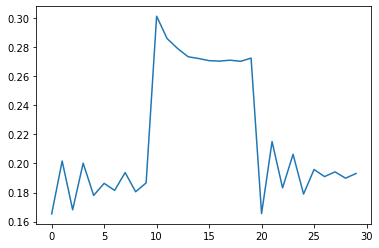

In [41]:
i=16
l = loss[:, i]
plt.plot(np.arange(len(l)), l)
plt.show()